# Assignment 3: Image Classification

In this assignment, we will build a convolutional neural network that can predict 
whether two shoes are from the **same pair** or from two **different pairs**.
This kind of application can have real-world applications: for example to help
people who are visually impaired to have more independence.

We will explore two convolutional architectures. While we will give you starter
code to help make data processing a bit easier, in this assignment you have a chance to build your neural network all by yourself. 

You may modify the starter code as you see fit, including changing the signatures of
functions and adding/removing helper functions. However, please make sure that we can understand what you are doing and why.
 

In [2]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pickle

## Question 1. Data (20%)

Download the data from the course website. 

Unzip the file. There are three
main folders: `train`, `test_w` and `test_m`. Data in `train` will be used for
training and validation, and the data in the other folders will be used for testing.
This is so that the entire class will have the same test sets. The dataset is comprised of triplets of pairs, where each such triplet of image pairs was taken in a similar setting (by the same person).

We've separated `test_w` and `test_m` so that we can track our model performance 
for women's shoes and men's shoes separately. Each of the test sets contain images of either exclusively men's shoes or women's
shoes.

Upload this data to Google Colab.
Then, mount Google Drive from your Google Colab notebook:

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


After you have done so, read this entire section 
before proceeding. There are right and wrong ways of
processing this data. If you don't make the correct choices, you may find
yourself needing to start over.
Many machine learning projects fail because of the lack of care taken during
the data processing stage.

### Part (a) -- 8%

Load the training and test data, and separate your training data into training and validation.
Create the numpy arrays `train_data`, `valid_data`, `test_w` and `test_m`, all of which should
be of shape `[*, 3, 2, 224, 224, 3]`. The dimensions of these numpy arrays are as follows:

- `*` - the number of triplets allocated to train, valid, or test
- `3` - the 3 pairs of shoe images in that triplet
- `2` - the left/right shoes
- `224` - the height of each image
- `224` - the width of each image
- `3` - the colour channels

So, the item `train_data[4,0,0,:,:,:]` should give us the left shoe of the first image of the fifth person.The item `train_data[4,0,1,:,:,:]`  should be the right shoe in the same pair. 
The item `train_data[4,1,1,:,:,:]`  should be the right shoe in a different pair of that same person.

When you first load the images using (for example) `plt.imread`, you may see a numpy array of shape
`[224, 224, 4]` instead of `[224, 224, 3]`. That last channel is what's called the alpha channel for transparent
pixels, and should be removed. 
The pixel intensities are stored as an integer between 0 and 255.
Make sure you normlize your images, namely, divide the intensities by 255 so that you have floating-point values between 0 and 1. Then, subtract 0.5
so that the elements of `train_data`, `valid_data` and `test_data` are between -0.5 and 0.5.
**Note that this step actually makes a huge difference in training!**

This function might take a while to run; it can takes several minutes to just
load the files from Google Drive.  If you want to avoid
running this code multiple times, you can save 
your numpy arrays and load it later:
https://docs.scipy.org/doc/numpy/reference/generated/numpy.save.html

In [4]:
# Your code goes here. Make sure it does not get cut off
# You can use the code below to help you get started. You're welcome to modify
# the code or remove it entirely: it's just here so that you don't get stuck
# reading files

import glob
path_train = "/content/gdrive/My Drive/DL/data/train/*.jpg"
path_test_m = "/content/gdrive/My Drive/DL/data/test_m/*.jpg"
path_test_w = "/content/gdrive/My Drive/DL/data/test_w/*.jpg"
path2save_train = "/content/gdrive/My Drive/DL/data/train.npy"
path2save_test_m = "/content/gdrive/My Drive/DL/data/test_m.npy"
path2save_test_w = "/content/gdrive/My Drive/DL/data/test_w.npy"

def file2dict(path,path2save):
  images = {}
  for file in glob.glob(path):
      filename = file.split("/")[-1]   # get the name of the .jpg file
      img = plt.imread(file)           # read the image as a numpy array
      images[filename] = img[:, :, :3] # remove the alpha channel
  with open(path2save, 'wb') as f:
    np.save(f, images)    
  return images

def dict2array(images):
  num_students = int(len(images)/6)
  output = np.zeros((num_students,3,2,224,224,3))
  last_student_num = 0
  student_idx = -1
  for file in sorted(images.keys()):
      student_num = int(file[1:4])
      if student_num != last_student_num:
        student_idx += 1
        last_student_num = student_num
      shoes_idx = int(file[5])-1  
      if file[7:11] == 'left':
        side_idx = 0
      else:
        side_idx = 1
      output[student_idx][shoes_idx][side_idx][:][:][:] = np.array(images[file])/255 - 0.5
  return output 

In [5]:
train_data_dict = file2dict(path_train,path2save_train) 
test_w_dict = file2dict(path_test_w,path2save_test_w)
test_m_dict = file2dict(path_test_m,path2save_test_m)

In [6]:
train_valid_data = dict2array(train_data_dict)
test_w = dict2array(test_w_dict)
test_m = dict2array(test_m_dict)

Spliting to train and validation sets

In [7]:
train_data = train_valid_data[0:round(0.9*len(train_valid_data)),:,:,:,:,:]
valid_data = train_valid_data[round(0.9*len(train_valid_data)):,:,:,:,:,:]

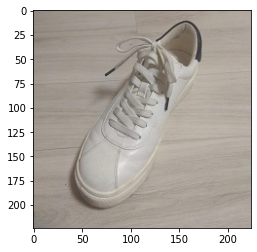

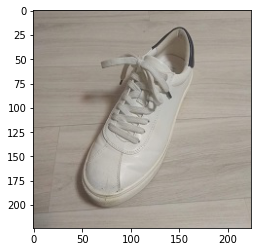

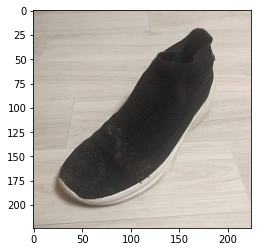

In [8]:
# Run this code, include the image in your PDF submission
plt.figure()
plt.imshow(train_data[4,0,0,:,:,:]+0.5) # left shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,0,1,:,:,:]+0.5) # right shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,1,1,:,:,:]+0.5) # right shoe of second pair submitted by 5th student

We added 0.5 to each image for showing the image in its natural brightness (pixels values between 0 to 1).

### Part (b) -- 4%

Since we want to train a model that determines whether two shoes come from the **same**
pair or **different** pairs, we need to create some labelled training data.
Our model will take in an image, either consisting of two shoes from the **same pair**
or from **different pairs**. So, we'll need to generate some *positive examples* with
images containing two shoes that *are* from the same pair, and some *negative examples* where 
images containing two shoes that *are not* from the same pair.
We'll generate the *positive examples* in this part, and the *negative examples* in the next part.

Write a function `generate_same_pair()` that takes one of the data sets that you produced
in part (a), and generates a numpy array where each pair of shoes in the data set is
concatenated together. In particular, we'll be concatenating together images of left
and right shoes along the **height** axis. Your function `generate_same_pair` should
return a  numpy array of shape `[*, 448, 224, 3]`.

While at this stage we are working with numpy arrays, later on, we will need to convert this numpy array into a PyTorch tensor with shape
`[*, 3, 448, 224]`. For now, we'll keep the RGB channel as the last dimension since
that's what `plt.imshow` requires.

(101, 3, 2, 224, 224, 3)
(303, 448, 224, 3)


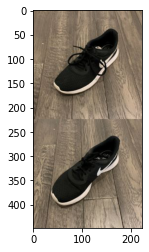

In [9]:
def generate_same_pair(dataset):
  output = np.empty((1, 448, 224, 3))
  for i in range(3):
    tmp = np.concatenate((dataset[:,i,0,:,:,:],dataset[:,i,1,:,:,:]),1)
    output = np.concatenate((output,tmp),0)
  return output[1:,:,:,:]

# Run this code, include the result with your PDF submission
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_same_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_same_pair(train_data)[0] + 0.5) # should show 2 shoes from the same pair

### Part (c) -- 4%

Write a function `generate_different_pair()` that takes one of the data sets that
you produced in part (a), and generates a numpy array in the same shape as part (b).
However, each image will contain 2 shoes from a **different** pair, but submitted
by the **same student**. Do this by jumbling the 3 pairs of shoes submitted by 
each student.

Theoretically, for each person (triplet of pairs), there are 6 different combinations
of "wrong pairs" that we could produce. To keep our data set *balanced*, we will
only produce **three** combinations of wrong pairs per unique person.
In other words,`generate_same_pairs` and `generate_different_pairs` should
return the same number of training examples.

(101, 3, 2, 224, 224, 3)
(303, 448, 224, 3)


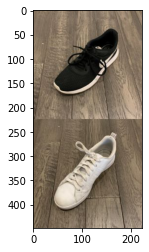

In [10]:
def generate_different_pair(dataset):
  output = np.empty((1, 448, 224, 3))
  for i in range(3):
    tmp = np.concatenate((dataset[:,i,0,:,:,:],dataset[:,(i+1)%3,1,:,:,:]),1)
    output = np.concatenate((output,tmp),0)
  return output[1:,:,:,:]

# Run this code, include the result with your PDF submission
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_different_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_different_pair(train_data)[0] + 0.5) # should show 2 shoes from different pairs

### Part (d) -- 2%

Why do we insist that the different pairs of shoes still come from the same
person?  (Hint: what else do images from the same person have in common?)

We do that because the images from the same person have the same background. If a shoe from a different pair will be in a different background it will be easier for the network to identify that the shoes don't fit.

In practice, the person who will use the network would probably take a photo of the shoes in the same room, so his/her photos will have the same background. Therefore, it will make more sense to train the network this way.

### Part (e) -- 2%

Why is it important that our data set be *balanced*? In other words suppose we created
a data set where 99% of the images are of shoes that are *not* from the same pair, and 
1% of the images are shoes that *are* from the same pair. Why could this be a problem?

This case could be a problem because it could lead to a biased network which declares that shoes came from different pairs almost every time, and will have high accuracy, for this data set. But, it won't have a good performance for real data set, where there are more pairs of fitting shoes.

## Question 2. Convolutional Neural Networks (25%)

Before starting this question, we recommend reviewing the lecture and its associated example notebook on CNNs.

In this section, we will build two CNN models in PyTorch.

### Part (a) -- 9%

Implement a CNN model in PyTorch called `CNN` that will take images of size
$3 \times 448 \times 224$, and classify whether the images contain shoes from
the same pair or from different pairs.

The model should contain the following layers:

- A convolution layer that takes in 3 channels, and outputs $n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A second convolution layer that takes in $n$ channels, and outputs $2\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A third convolution layer that takes in $2\cdot n$ channels, and outputs $4\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fourth convolution layer that takes in $4\cdot n$ channels, and outputs $8\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fully-connected layer with 100 hidden units
- A fully-connected layer with 2 hidden units

Make the variable $n$ a parameter of your CNN. You can use either $3 \times 3$ or $5 \times 5$
convolutions kernels. Set your padding to be `(kernel_size - 1) / 2` so that your feature maps
have an even height/width.

Note that we are omitting in our description certain steps that practitioners will typically not mention,
like ReLU activations and reshaping operations. Use the example presented in class to figure out where they are.

In [103]:
class CNN(nn.Module):
    def __init__(self, n=4):
        super(CNN, self).__init__()
        self.n = n
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n, kernel_size=5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(n, 2*n, kernel_size=5, stride=2, padding=2)
        self.conv3 = nn.Conv2d(2*n, 4*n, kernel_size=5, stride=2, padding=2)
        self.conv4 = nn.Conv2d(4*n, 8*n, kernel_size=5, stride=2, padding=2)
        self.fc1 = nn.Linear(8*n*28*14, 100)
        self.fc2 = nn.Linear(100, 2)

        nn.init.normal_(self.conv1.weight, mean=0, std=0.5)
        nn.init.normal_(self.conv2.weight, mean=0, std=0.5)
        nn.init.normal_(self.conv3.weight, mean=0, std=0.5)
        nn.init.normal_(self.conv4.weight, mean=0, std=0.5)
        nn.init.normal_(self.fc1.weight, mean=0, std=0.5)
        nn.init.normal_(self.fc2.weight, mean=0, std=0.5)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.leaky_relu(x)
        x = self.conv2(x)
        x = F.leaky_relu(x)
        x = self.conv3(x)
        x = F.leaky_relu(x)
        x = self.conv4(x)
        x = F.leaky_relu(x)        
        x = x.view(-1, 8*self.n*28*14)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        # x = F.relu(x)
        return x

### Part (b) -- 8%

Implement a CNN model in PyTorch called `CNNChannel` that contains the same layers as
in the Part (a), but with one crucial difference: instead of starting with an image
of shape $3 \times 448 \times 224$, we will first manipulate the image so that the
left and right shoes images are concatenated along the **channel** dimension.

<img src="https://drive.google.com/uc?id=1B59VE43X-6Dw3ag-9Ndn6vPEzbnFem8K" width="400px" />


Complete the manipulation in the `forward()` method (by slicing and using
the function `torch.cat`). The input to the first convolutional layer
should have 6 channels instead of 3 (input shape $6 \times 224 \times 224$).

Use the same hyperparameter choices as you did in part (a), e.g. for the kernel size,
choice of downsampling, and other choices.

In [95]:
class CNNChannel(nn.Module):
    def __init__(self, n=4):
        super(CNNChannel, self).__init__()
        self.n = n
        self.conv1 = nn.Conv2d(in_channels=6, out_channels=n, kernel_size=5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(n, 2*n, kernel_size=5, stride=2, padding=2)
        self.conv3 = nn.Conv2d(2*n, 4*n, kernel_size=5, stride=2, padding=2)
        self.conv4 = nn.Conv2d(4*n, 8*n, kernel_size=5, stride=2, padding=2)
        self.fc1 = nn.Linear(8*n*14*14, 100)
        self.fc2 = nn.Linear(100, 2)

        nn.init.normal_(self.conv1.weight, mean=0, std=0.05)
        nn.init.normal_(self.conv2.weight, mean=0, std=0.05)
        nn.init.normal_(self.conv3.weight, mean=0, std=0.05)
        nn.init.normal_(self.conv4.weight, mean=0, std=0.05)
        nn.init.normal_(self.fc1.weight, mean=0, std=0.05)
        nn.init.normal_(self.fc2.weight, mean=0, std=0.05)
        
    def forward(self, x, verbose=False):
        img1 = x[:,:,0:224,:]
        img2 = x[:,:,224:,:]
        x = torch.cat((img1,img2),1)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)        
        x = x.view(-1, 8*self.n*14*14)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        # x = F.relu(x)
        return x

## Part (c) -- 4%

The two models are quite similar, and should have almost the same number of parameters.
However, one of these models will perform better, showing that architecture choices **do**
matter in machine learning. Explain why one of these models performs better.

In general, the CNN model is based on the neighbor pixels correlations, meaning that in each calculation, pixels which are farther from each other will have significantly less influence (or maybe not at all, depand on the number of layers and kernel size). The second model performs better because the CNNChannel can proccess spatially the same area in both images simultaniously, which the first model of CNN could not perform.

## Part (d) -- 4%

The function `get_accuracy` is written for you. You may need to modify this
function depending on how you set up your model and training.

Unlike in the previous assignment, her we will separately compute the model accuracy on the
positive and negative samples.  Explain why we may wish to track the false positives and false negatives separately.

We wish to track the false positives and false negatives separately in order to get a clearer picture for the accuracy of our model. If we will compute a general accuracy for both cases, we wouldn't know where the problem in the network is. For example, if we will recieve 50% general accuracy, it could be because the network always predicted 'positive', which will lead to 100% positive accuracy and 0% negative accuracy, or it could be also the case where both the accuracies are 50%.  

In [13]:
def get_accuracy(model, data, batch_size=50):
    """Compute the model accuracy on the data set. This function returns two
    separate values: the model accuracy on the positive samples,
    and the model accuracy on the negative samples.

    Example Usage:

    >>> model = CNN() # create untrained model
    >>> pos_acc, neg_acc= get_accuracy(model, valid_data)
    >>> false_positive = 1 - pos_acc
    >>> false_negative = 1 - neg_acc
    """

    model.eval()
    n = data.shape[0]

    data_pos = generate_same_pair(data)      # should have shape [n * 3, 448, 224, 3]
    data_neg = generate_different_pair(data) # should have shape [n * 3, 448, 224, 3]

    pos_correct = 0
    for i in range(0, len(data_pos), batch_size):
        xs = torch.Tensor(data_pos[i:i+batch_size]).permute(0,3,1,2)

        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        pos_correct += (pred == 1).sum()
    
    neg_correct = 0
    for i in range(0, len(data_neg), batch_size):
        xs = torch.Tensor(data_neg[i:i+batch_size]).permute(0,3,1,2)

        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        neg_correct += (pred == 0).sum()

    return pos_correct / (n * 3), neg_correct / (n * 3)

## Question 3. Training (40%)

Now, we will write the functions required to train the model. 

Although our task is a binary classification problem, we will still use the architecture
of a multi-class classification problem. That is, we'll use a one-hot vector to represent
our target (like we did in the previous assignment). We'll also use `CrossEntropyLoss` instead of
`BCEWithLogitsLoss` (this is a standard practice in machine learning because
this architecture often performs better).

### Part (a) -- 22%

Write the function `train_model` that takes in (as parameters) the model, training data,
validation data, and other hyperparameters like the batch size, weight decay, etc.
This function should be somewhat similar to the training code that you wrote
in Assignment 2, but with a major difference in the way we treat our training data.

Since our positive (shoes of the same pair) and negative (shoes of different pairs) training sets are separate, it is actually easier for
us to generate separate minibatches of positive and negative training data.
 In
each iteration, we'll take `batch_size / 2` positive samples and `batch_size / 2`
negative samples. We will also generate labels of 1's for the positive samples,
and 0's for the negative samples.

Here is what your training function should include:

- main training loop; choice of loss function; choice of optimizer
- obtaining the positive and negative samples
- shuffling the positive and negative samples at the start of each epoch
- in each iteration, take `batch_size / 2` positive samples and `batch_size / 2` negative samples
  as our input for this batch
- in each iteration, take `np.ones(batch_size / 2)` as the labels for the positive samples, and 
  `np.zeros(batch_size / 2)` as the labels for the negative samples
- conversion from numpy arrays to PyTorch tensors, making sure that the input has dimensions $N \times C \times H \times W$ (known as NCHW tensor), where $N$ is the number of images batch size, $C$ is the number of channels, $H$ is the height of the image, and $W$ is the width of the image. 
- computing the forward and backward passes 
- after every epoch, report the accuracies for the training set and validation set
- track the training curve information and plot the training curve

It is also recommended to checkpoint your model (save a copy) after every epoch, as we did in Assignment 2.

In [58]:
def train_model(model,
                training_data=train_data,
                validation_data=valid_data,
                batch_size=24,
                learning_rate=0.001,
                weight_decay=10**(-5),
                max_iters=100,
                checkpoint_path=None):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay)

    train_dif = generate_different_pair(training_data)
    train_same = generate_same_pair(training_data)    

    iters, losses = [], []
    iters_sub, pos_accs, neg_accs, val_pos_accs, val_neg_accs  = [], [] ,[], [], []

    best_acc = 0

    n = 0 # the number of iterations
    while True:
        np.random.shuffle(train_dif)
        np.random.shuffle(train_same)
        train_dif = torch.Tensor(train_dif)
        train_same = torch.Tensor(train_same)
        for i in range(0, train_dif.shape[0], batch_size//2):
            if (i + batch_size//2) > train_dif.shape[0]:
                break
            # get the input and targets of a minibatch
            xt = torch.cat((train_dif[i:i+batch_size//2,:,:,:],train_same[i:i+batch_size//2,:,:,:]),0)
            st = torch.Tensor(np.concatenate((np.zeros(batch_size//2),torch.Tensor(np.ones(batch_size//2))),0))
            
            # convert from numpy arrays to PyTorch tensors
            xt = np.transpose(torch.Tensor(xt),(0,3,1,2))
            st = torch.Tensor(st).long()

            optimizer.zero_grad()          # a clean up step for PyTorch
            zs = model(xt)                 # compute prediction logit
            loss = criterion(zs,st)        # compute the total loss
            loss.backward()                # compute updates for each parameter
            optimizer.step()               # make the updates for each parameter

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)  # compute *average* loss

            if n % 10 == 0:
                iters_sub.append(n)
                train_cost = float(loss.detach().numpy())

                pos_acc, neg_acc = get_accuracy(model, training_data, batch_size)
                pos_accs.append(pos_acc)
                neg_accs.append(neg_acc)

                val_pos_acc, val_neg_acc = get_accuracy(model, validation_data, batch_size)
                val_pos_accs.append(val_pos_acc)
                val_neg_accs.append(val_neg_acc)

                print("Iter %d. [Val Pos Acc %.0f%%] [Val Neg Acc %.0f%%] [Train Pos Acc %.0f%%, Train Neg Acc %.0f%% Loss %f]" % (
                      n, val_pos_acc * 100, val_neg_acc * 100, pos_acc * 100, neg_acc * 100, train_cost))

                # if (checkpoint_path is not None) and n > 0:
                #     torch.save(model.state_dict(), checkpoint_path.format(n))
                
                tot_acc = (val_pos_acc+val_neg_acc)/2
                if tot_acc > best_acc:
                  best_acc = tot_acc
                  torch.save(model,checkpoint_path)


            # increment the iteration number
            n += 1

            if n > max_iters:
                return iters, losses, iters_sub, pos_accs, neg_accs, val_pos_accs, val_neg_accs


### Part (b) -- 6%

Sanity check your code from Q3(a) and from Q2(a) and Q2(b) by showing that your models
can memorize a very small subset of the training set (e.g. 5 images).
You should be able to achieve 90%+ accuracy (don't forget to calculate the accuracy)
relatively quickly (within ~30 or so iterations).


(Start with the second network, it is easier to converge)

Try to find the general parameters combination that work for each network, it can help you a little bit later.

Iter 0. [Val Pos Acc 47%] [Val Neg Acc 60%] [Train Pos Acc 47%, Train Neg Acc 60% Loss 664034.437500]
Iter 10. [Val Pos Acc 33%] [Val Neg Acc 87%] [Train Pos Acc 33%, Train Neg Acc 87% Loss 0.000000]
Iter 20. [Val Pos Acc 33%] [Val Neg Acc 87%] [Train Pos Acc 33%, Train Neg Acc 87% Loss 0.000000]
Iter 30. [Val Pos Acc 33%] [Val Neg Acc 87%] [Train Pos Acc 33%, Train Neg Acc 87% Loss 0.000000]


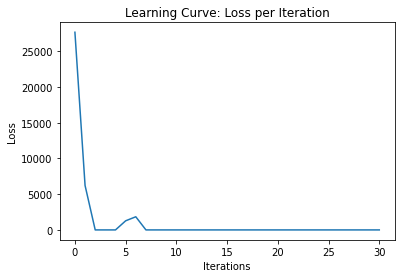

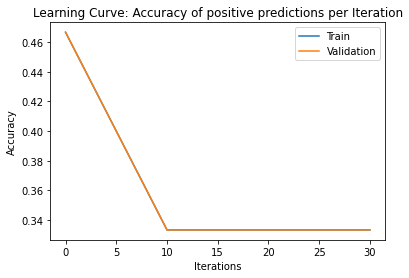

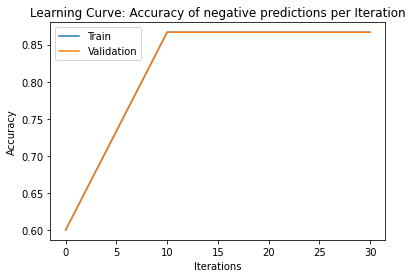

In [87]:
# Write your code here. Remember to include your results so that we can
# see that your model attains a high training accuracy.

small_train_data = train_data[:5]

def plot_learning_curve(iters, losses, iters_sub, train_pos_accs, train_neg_accs, val_pos_accs, val_neg_accs):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve: Accuracy of positive predictions per Iteration")
    plt.plot(iters_sub, train_pos_accs, label="Train")
    plt.plot(iters_sub, val_pos_accs, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    plt.title("Learning Curve: Accuracy of negative predictions per Iteration")
    plt.plot(iters_sub, train_neg_accs, label="Train")
    plt.plot(iters_sub, val_neg_accs, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

model = CNNChannel()
learning_curve_info = train_model(model,
                training_data=small_train_data,
                validation_data=small_train_data,
                batch_size=24,
                learning_rate=0.001,
                max_iters=30,
                checkpoint_path=None)

plot_learning_curve(*learning_curve_info)

In [80]:
torch.save(model, '/content/gdrive/My Drive/DL/Ex3_best_model.pt')

### Part (c) -- 8%

Train your models from Q2(a) and Q2(b). Change the values of a few 
hyperparameters, including the learning rate, batch size, choice of $n$, and 
the kernel size. You do not need to check all values for all hyperparameters. Instead, try to make big changes to see how each change affect your scores.
(try to start with finding a resonable learning rate for each network, that start changing the other parameters, the first network might need bigger $n$ and kernel size)

In this section, explain how you tuned your hyperparameters.

**Write your explanation here:**

Iter 0. [Val Pos Acc 61%] [Val Neg Acc 64%] [Train Pos Acc 88%, Train Neg Acc 56% Loss 57247.332031]
Iter 10. [Val Pos Acc 45%] [Val Neg Acc 70%] [Train Pos Acc 74%, Train Neg Acc 76% Loss 39589.972656]
Iter 20. [Val Pos Acc 39%] [Val Neg Acc 76%] [Train Pos Acc 70%, Train Neg Acc 85% Loss 25680.021484]
Iter 30. [Val Pos Acc 42%] [Val Neg Acc 73%] [Train Pos Acc 86%, Train Neg Acc 84% Loss 19822.908203]
Iter 40. [Val Pos Acc 76%] [Val Neg Acc 55%] [Train Pos Acc 98%, Train Neg Acc 54% Loss 14462.788086]
Iter 50. [Val Pos Acc 27%] [Val Neg Acc 91%] [Train Pos Acc 60%, Train Neg Acc 96% Loss 0.000000]
Iter 60. [Val Pos Acc 36%] [Val Neg Acc 85%] [Train Pos Acc 74%, Train Neg Acc 87% Loss 5151.631348]
Iter 70. [Val Pos Acc 45%] [Val Neg Acc 76%] [Train Pos Acc 85%, Train Neg Acc 82% Loss 5067.842773]
Iter 80. [Val Pos Acc 58%] [Val Neg Acc 73%] [Train Pos Acc 91%, Train Neg Acc 74% Loss 6118.032715]
Iter 90. [Val Pos Acc 30%] [Val Neg Acc 82%] [Train Pos Acc 71%, Train Neg Acc 91% Loss 36

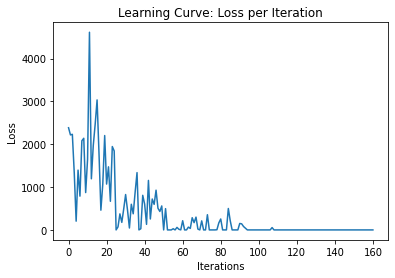

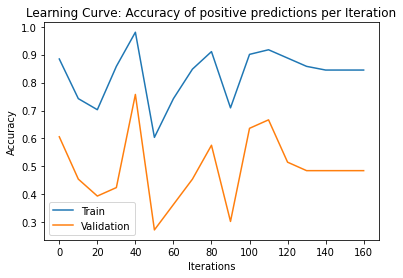

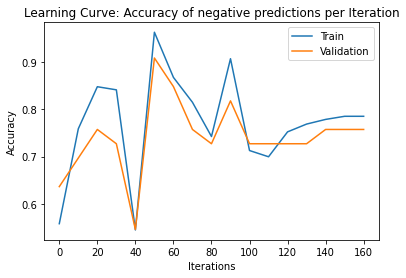

In [106]:
# Include the training curves for the two models.

# Write your code here. Remember to include your results so that we can
# see that your model attains a high training accuracy.

learning_curve_info = train_model(model,
                training_data=train_data,
                validation_data=valid_data,
                batch_size=24,
                learning_rate=0.003,
                weight_decay=10**(-5),
                max_iters=160,
                checkpoint_path='/content/gdrive/My Drive/DL/Ex3_best_model.pt')

plot_learning_curve(*learning_curve_info)

Iter 0. [Val Pos Acc 100%] [Val Neg Acc 0%] [Train Pos Acc 97%, Train Neg Acc 3% Loss 8614.101562]
Iter 10. [Val Pos Acc 64%] [Val Neg Acc 33%] [Train Pos Acc 65%, Train Neg Acc 35% Loss 1456.202759]
Iter 20. [Val Pos Acc 27%] [Val Neg Acc 67%] [Train Pos Acc 27%, Train Neg Acc 74% Loss 1188.328003]
Iter 30. [Val Pos Acc 61%] [Val Neg Acc 36%] [Train Pos Acc 65%, Train Neg Acc 36% Loss 612.294434]
Iter 40. [Val Pos Acc 30%] [Val Neg Acc 64%] [Train Pos Acc 44%, Train Neg Acc 65% Loss 333.906555]
Iter 50. [Val Pos Acc 48%] [Val Neg Acc 48%] [Train Pos Acc 57%, Train Neg Acc 58% Loss 6.808207]
Iter 60. [Val Pos Acc 52%] [Val Neg Acc 45%] [Train Pos Acc 65%, Train Neg Acc 47% Loss 50.025608]
Iter 70. [Val Pos Acc 45%] [Val Neg Acc 48%] [Train Pos Acc 61%, Train Neg Acc 57% Loss 18.853521]
Iter 80. [Val Pos Acc 39%] [Val Neg Acc 52%] [Train Pos Acc 62%, Train Neg Acc 59% Loss 0.551061]
Iter 90. [Val Pos Acc 42%] [Val Neg Acc 52%] [Train Pos Acc 60%, Train Neg Acc 59% Loss 3.138654]
Iter 10

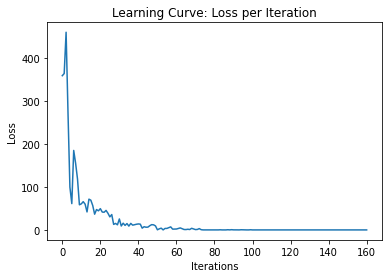

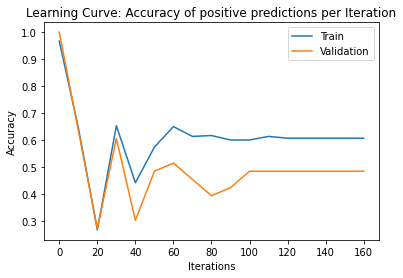

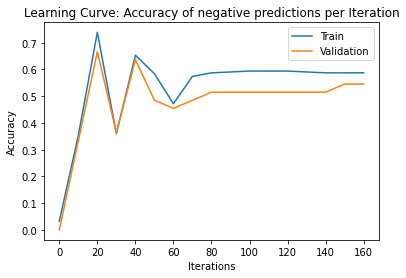

In [107]:
model2 = CNN()
learning_curve_info = train_model(model2,
                training_data=train_data,
                validation_data=valid_data,
                batch_size=24,
                learning_rate=0.003,
                weight_decay=10**(-5),
                max_iters=160,
                checkpoint_path='/content/gdrive/My Drive/DL/Ex3_best_model2.pt')

plot_learning_curve(*learning_curve_info)

### Part (d) -- 4%

Include your training curves for the **best** models from each of Q2(a) and Q2(b).
These are the models that you will use in Question 4.

In [ ]:
# Include the training curves for the two models.

## Question 4. Testing (15%)

### Part (a) -- 7%

Report the test accuracies of your **single best** model,
separately for the two test sets.
Do this by choosing the  model
architecture that produces the best validation accuracy. For instance,
if your model attained the
best validation accuracy in epoch 12, then the weights at epoch 12 is what you should be using
to report the test accuracy.

In [112]:
model = CNNChannel()
model.load_state_dict(torch.load('/content/gdrive/My Drive/DL/Ex3_best_model.pt'))

model2 = CNN()
model2.load_state_dict(torch.load('/content/gdrive/My Drive/DL/Ex3_best_model2.pt'))

test_m_acc_pos, test_m_acc_neg =get_accuracy(model,test_m, batch_size=10)
total_acc_test_m=(test_m_acc_pos+test_m_acc_neg)/2

test_w_acc_pos, test_w_acc_neg=get_accuracy(model,test_w, batch_size=10)
total_acc_test_w=(test_w_acc_pos+test_w_acc_neg)/2

print('test_m: Total accuracy = {:.2f}% positive accuracy = {:.2f}% negative accuracy = {:.2f}%'.format(100*total_acc_test_m,100*test_m_acc_pos,100*test_m_acc_neg))
print('test_w: Total accuracy = {:.2f}% positive accuracy = {:.2f}% negative accuracy = {:.2f}%'.format(100*total_acc_test_w,100*test_w_acc_pos,100*test_w_acc_neg))

test_m: Total accuracy = 51.67% positive accuracy = 53.33% negative accuracy = 50.00%
test_w: Total accuracy = 56.67% positive accuracy = 60.00% negative accuracy = 53.33%


### Part (b) -- 4%

Display one set of men's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the men's shoes test set,
display one set of inputs that your model classified incorrectly.



### Part (c) -- 4%

Display one set of women's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the women's shoes test set,
display one set of inputs that your model classified incorrectly.